#**HW7: Point Models**
*CS4610/5335: Robotic Science and Systems (Spring 2023) | Robert Platt | Northeastern University*

--------------------------

Please remember the following policies:
- Submissions should be made electronically via the Canvas. For this assignment, you should submit both a *.ipynb and *.pdf version of your completed Colab notebook as a single zipped file.
- You are welcome to discuss the programming questions (but not the written questions) with other students in the class. However, you must understand and write all code yourself. Also, you must list all students (if any)
with whom you discussed your solutions to the programming questions.
- Please provide comments in your code to make it understandable to the graders. 

<style type="text/css">
    ol { list-style-type: upper-alpha; }
</style>

---

*By defualt, the notebook is on CPU runtime.  Due to restrictions on GPU-usage, we recommend switching to GPU runtime only when you are ready to train the models, and ending the runtime session when not in use.  You can make these changes using the 'Runtime' tab on the top panel.*

---


# Utils and Imports
Run the code cells below before you start working on the rest of the notebook.

In [ ]:
%%capture
! pip install plotly scikit-learn scipy
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12SKS8uRk_w5xi5b45ipX7lFW6GLfAbjY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12SKS8uRk_w5xi5b45ipX7lFW6GLfAbjY" -O mug_partnet.npz && rm -rf /tmp/cookies.txt

In [ ]:
from typing import Tuple
import numpy as np
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, random_split
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from scipy.spatial.transform import Rotation

In [ ]:
def plot_pointcloud(pc, labels, preds, grasp_pose=None):
  cmap_bwr = [[0, 'rgb(0,50,255)'], [0.5, 'rgb(200,200,200)'], [1, 'rgb(255,50,0)']]
  traces = [
    go.Scatter3d(
      x=pc[..., 0].flatten() - 1,
      y=pc[..., 1].flatten(),
      z=pc[..., 2].flatten(),
      mode='markers',
      marker=dict(
          size=6,
          color=labels.flatten(),
          colorscale=cmap_bwr, 
      ),
    ),
    go.Scatter3d(
      x=pc[..., 0].flatten() + 1,
      y=pc[..., 1].flatten(),
      z=pc[..., 2].flatten(),
      mode='markers',
      marker=dict(
          size=6,
          color=preds.flatten(),
          colorscale=cmap_bwr, 
      ),
    )
  ]
  if grasp_pose is not None:
    gripper_lines = np.array([
      [0, 0, -0.2],
      [0, -0.3, -0.2],
      [0, -0.3, 0],
      [0, -0.5, 0],
      [0, -0.3, 0],
      [0, -0.3, 0.2],
      [0, 0, 0.2],
    ])
    gripper_lines = (grasp_pose[:3, :3] @ gripper_lines.T).T + grasp_pose[:3, 3]
    traces.append(
      go.Scatter3d(
        x=gripper_lines[:, 0] + 1,
        y=gripper_lines[:, 1],
        z=gripper_lines[:, 2],
        mode='lines',
        line=dict(width=20),
        name='grasp'
      ),
    )

  fig = go.Figure(
    data=traces,
    layout=dict(
      scene=dict(
        xaxis=dict(range=[-2.1, 2.1]),
        yaxis=dict(range=[-1.1, 1.1]),
        zaxis=dict(range=[-1.1, 1.1]),
        aspectmode='manual',
        aspectratio=dict(x=4, y=2, z=2),
        camera=dict(
          up=dict(x=0, y=0, z=1),
          center=dict(x=0, y=0, z=0),
          eye=dict(x=0, y=-5, z=5),
          projection=dict(type='orthographic'),
        ),
      ),
      width=1000,
      height=500,
      margin=dict(l=0, r=0, t=0, b=0),
      plot_bgcolor="rgba(0,0,0,0)",
      paper_bgcolor="rgba(0,0,0,0)",
    )
  )
  fig.show()

def q1a_checker(tnet: nn.Module):
  num_params = sum(p.numel() for p in tnet(3).parameters() if p.requires_grad)
  assert num_params == 799113, (
      f'Incorrect number of parameters. Expected 799113, found {num_params}.'
  )
  
  x = torch.randn((1, 3, 127))
  out = tnet(k=3)(x)
  assert out.shape == (1, 3, 3), (
      f'Incorrect output shape. Expected (3, 3), found {out.shape[1:]}.'
  )

  x = torch.randn((1, 64, 317))
  out = tnet(k=64)(x)
  assert out.shape == (1, 64, 64), (
      f'Incorrect output shape. Expected (64, 64), found {out.shape[1:]}.'
  )
  print('Q1a: PASSED')


def q1b_checker(pnet: nn.Module):
  net = pnet()

  num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  assert num_params == 2801481, (
      f'Incorrect number of parameters. Expected 2801481, found {num_params}.'
  )
  
  net = pnet()
  x = torch.randn((1, 3, 163))
  gfeat, lfeat, _, _ = net(x)
  assert gfeat.shape == (1, 1024), (
      f'Incorrect global feature shape. Expected (1024, ), found {gfeat.shape[1:]}.'
  )

  assert lfeat.shape == (1, 64, 163), (
      f'Incorrect local feature shape. Expected (64, 163), found {lfeat.shape[1:]}.'
  )

  x_shuffled = x[:, :, torch.randperm(163)]
  gfeat_shuffled, lfeat_shuffled, _, _ = net(x_shuffled)
  assert torch.allclose(gfeat, gfeat_shuffled), (
      f'Incorrect implementation, expected global features to be invariant to point ordering.'
  )

  print('Q1b: PASSED')

# Q1. Implementing [PointNet](https://openaccess.thecvf.com/content_cvpr_2017/papers/Qi_PointNet_Deep_Learning_CVPR_2017_paper.pdf) [3 pts]
In this question, you will implement the backbone of PointNet (e.g. everything except the prediction head).  There are checker functions that can be used as a sanity check that your implementation is correct.

a.   Implement the TNet module below.  See the docstring for more information.

b.   Implement the PointNetBackbone module below.  The backbone should implement all operations shown in the image below.  Place a ReLU between each linear operation in the MLPs.  See docstring for what parameters to return.

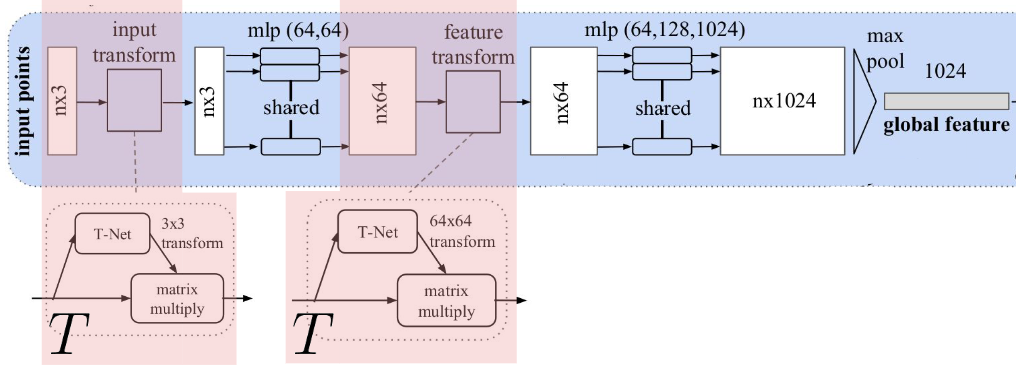

c.   Why is invariance to ordering an important property for a point cloud network?  What makes PointNet invariant to the order of the points in the input?

[*place answer to Q1c here*]



In [ ]:
class TNet(nn.Module):
  def __init__(self, k: int):
    '''Module that predicts a k-by-k transformation matrix 

    The layers are described below.  Please follow this description, even though
    it differs slightly from what was presented in lecture.  Do not use batchnorms
    anywhere in this module:

    1. SharedMLP: three linear layers with output dimensions of 64, 128, and 1024, 
                  respectively.  Include relu's after each linear operation
    2. Max pool operation over all points (dim=1)
    3. Flatten operation to generate tensor of shape (batch_size, 1024)
    4. MLP: three linear layers with output dimensions of 512, 256, and k*k, respectively.
            Include ReLU's *between* the layers (NOT ON OUTPUT!)
    5. Reshape operation to produce tensor of shape (batch_size, k, k)

    Hint
    ----
    `nn.Conv1d` is a simple way to share the same linear operation 
    '''
    super().__init__()
    self.k = k

    # Define the shared MLP layers using 1D convolutions
    self.shared_mlp = nn.Sequential(
        nn.Conv1d(k, 64, 1),
        nn.ReLU(),
        nn.Conv1d(64, 128, 1),
        nn.ReLU(),
        nn.Conv1d(128, 1024, 1),
        nn.ReLU()
    )

    # Define the MLP layers using linear operations
    self.mlp = nn.Sequential(
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, k * k)
    )

  def forward(self, x: Tensor):
    '''Performs forward pass

    Arguments
    ---------
    x : tensor of shape (B, 3, N) where B is batch size
        and N is the number of points
    
    Returns
    -------
    tensor of shape (B, self.k, self.k)
    '''
    # 1. SharedMLP: three linear layers with output dimensions of 64, 128, and 1024, 
    # respectively.  Include relu's after each linear operation
    x = self.shared_mlp(x)

    # 2. Max pool operation over all points (dim=1)
    x = nn.MaxPool1d(x.shape[2])(x)

    # 3. Flatten operation to generate tensor of shape (batch_size, 1024)
    x = x.view(-1, 1024)

    # 4. MLP: three linear layers with output dimensions of 512, 256, and k*k, respectively.
    # Include ReLU's *between* the layers (NOT ON OUTPUT!)
    x = self.mlp(x)

    # 5. Reshape operation to produce tensor of shape (batch_size, k, k)
    x = x.view(-1, self.k, self.k)
    return x


class PointNetBackbone(nn.Module):
  def __init__(self):
    '''PointNet network without predictions head, see picture for more information.

    USE ReLU BETWEEN ALL LINEAR LAYERS IN MLP!! For instance, "mlp(64,64)" 
    corresponds to two linear operations with output dimensions of 64 and 64, 
    with a ReLU between them
    '''
    super().__init__()
    
    # First TNet module for input transform
    self.input_transform = TNet(k=3)

    # Shared MLP layers for local features (two 1D conv layers with ReLU activations)
    self.shared_mlp_1 = nn.Sequential(
        nn.Conv1d(3, 64, 1),
        nn.ReLU(),
        nn.Conv1d(64, 64, 1),
        nn.ReLU()
    )

    # Second TNet module for feature transform
    self.feature_transform = TNet(k=64)

    # Shared MLP layers for global features (three 1D conv layers with ReLU activations)
    self.shared_mlp_2 = nn.Sequential(
        nn.Conv1d(64, 64, 1),
        nn.ReLU(),
        nn.Conv1d(64, 128, 1),
        nn.ReLU(),
        nn.Conv1d(128, 1024, 1),
        nn.ReLU()
    )

  def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
    '''Perform forward pass, returning additional intermediate features which are
    needed for subsequent processing or computing loss terms

    Arguments
    ---------
    x : point cloud, float tensor of shape (B, 3, N)

    Returns
    -------
    global_feature: float tensor of shape (B, 1024) generated by max pool operation
    point_features: float tensor of shape (B, 64, N), features produced by feature
                    transform operation
    input_transform: float tensor of shape (B, 3, 3); input transformation matrix
                     produced by first TNet module
    feature_transform: float tensor of shape (B, 64, 64); feature transformation matrix
                     produced by second TNet module
    '''
    B, _, N = x.size()
    
    # Compute the input transform matrix
    input_transform = self.input_transform(x)

    # Apply the input transform to the input point cloud
    x_transformed = torch.bmm(input_transform, x)
    
    # Extract local features using the first shared MLP
    point_features = self.shared_mlp_1(x_transformed)
    
    # Compute the feature transform matrix
    feature_transform = self.feature_transform(point_features)

    # Apply the feature transform to the local features
    local_features_transformed = torch.bmm(feature_transform, point_features)
    
    # Extract global features using the second shared MLP
    global_features = self.shared_mlp_2(local_features_transformed)
    # Perform max pooling to obtain the global feature
    global_feature = torch.max(global_features, 2, keepdim=True)[0]
    global_feature = global_feature.view(B, -1)
    
    return global_feature, point_features, input_transform, feature_transform

q1a_checker(TNet)
q1b_checker(PointNetBackbone)

Q1a: PASSED
Q1b: PASSED


# Q2. PointNet for Segmentation [4 pts]
The output of the PointNet backbone is a global feature vector. As discussed in class, this can be used to make predictions about the entire point cloud.  For this assignment, we want the ability to make predictions on a point-by-point basis.  For instance, given a point cloud of a coffee mug, we want the network to predict which points belong to the handle.  In this question, you will implement a PointNet model for point cloud segmentation, implement auxilliary loss functions and then train it to segment coffee mug handles.

a.   Implement the PointNetSeg module below (`__init__` and `forward` methods).  This network broadcasts the global feature vector to all point-wise features then performs additional point-wise processing. See picture below for more information (you already implemented the top row with `PointNetBackbone`)
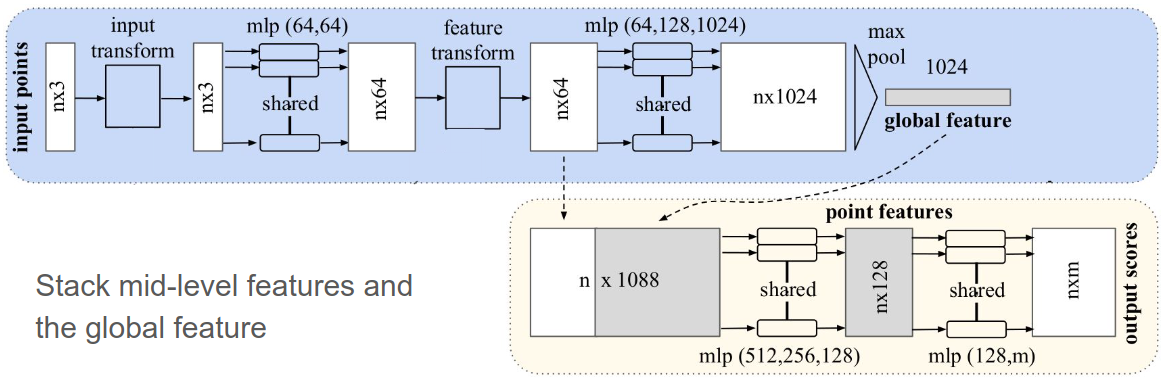

b.   Complete the `compute_losses` method, which applies a cross entropy loss to predict better class scores and a regularization loss to push the learned transformation matrices to be orthogonal.

c.   We are almost ready for training.  The dataset has been defined for you below.  Notice that the point cloud is transformed so its center of mass is zero and the maximum magnitude is 1.  Why is it smart to center and normalize the point cloud in this way before passing it as input to the network?  Consider how this changes the networks ability to generalize.

[*place answer to Q2c here*]

d.   Run the code cell to train the network for 20 epochs then plot the predictions.  Uncomment the section in the prediction code to test how the network does on a subset of the point cloud.  How does the network perform on the subset compared to the full point cloud?  

In [ ]:
class PointNetSeg(nn.Module):
  def __init__(self, num_classes: int):
    '''PointNet model with dense output that predicts per-pixel class labels

    Use the PointNetBackbone.  First broadcast the global feature to every point
    then concatenate the global features and point features to create a (B, 1088, N)
    tensor.  Then use a shared MLP to generate the output scores: a tensor of 
    shape (B, num_classes, N)
    '''
    super().__init__()
    self.backbone = PointNetBackbone()

    # Store the number of classes to predict
    self.num_classes = num_classes

    # Define the segmentation network that takes the concatenated global and point features
    # and processes them through a series of 1D convolutional layers with ReLU activation functions
    self.segmentation_network = nn.Sequential(
        nn.Conv1d(1088, 512, 1),
        nn.ReLU(),
        nn.Conv1d(512, 256, 1),
        nn.ReLU(),
        nn.Conv1d(256, 128, 1),
        nn.ReLU()
    )

    # Define the final shared Multi-Layer Perceptron (MLP) that maps the output
    # of the segmentation network to the per-point class predictions
    self.mlp = nn.Sequential(
        nn.Conv1d(128, 128, 1),
        nn.ReLU(),
        nn.Conv1d(128, self.num_classes, 1),
    )

  def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
    '''Perform forward pass

    Arguments
    ---------
    x: point cloud, float tensor of shape (B, 3, N)

    Returns
    -------
    tuple:
      output_scores: float tensor of per-point logits; shape (B, num_classes, N)
      input_transform: float tensor of shape (3, 3); provided by PointNetBackbone.forward
      feature_transform: float tensor of shape (64, 64); provided by PointNetBackbone.forward
    '''
    # Obtain global features, point features, input_transform, and feature_transform
    # from the PointNet backbone
    global_feature, point_features, input_transform, feature_transform = self.backbone(x)

    # Expand global_feature tensor by adding a new dimension and broadcasting it
    # to match the shape of point_features
    global_feature_expanded = global_feature.unsqueeze(2).expand(-1, -1, point_features.shape[2])

    # Concatenate global feature to point-wise features
    x = torch.cat([point_features, global_feature_expanded], dim=1)
    
    # Pass through segmentation network
    x = self.segmentation_network(x)

    # Calculate point features
    point_features = x * 128

    # Pass through final MLP to generate output scores
    output_scores = self.mlp(point_features)

    return output_scores, input_transform, feature_transform

  @torch.no_grad()
  def predict(self, x: Tensor):
    '''Predict class labels for each point in point cloud

    Arguments
    ---------
    x: point cloud, float tensor of shape (B, 3, N)

    Returns
    -------
    per-point class labels, long tensor of shape (B, N)
    '''
    out = self.forward(x)[0]
    return torch.argmax(out, dim=1)

  def compute_losses(self, x: Tensor, labels: Tensor) -> Tuple[Tensor, Tensor]:
    '''Compute losses

    Arguments
    ---------
    x: point cloud, float tensor of shape (B, 3, N)
    labels: per-point class labels, long tensor of shape (B, N)

    Returns
    -------
    tuple:
      cls_loss: classification loss generated by `nn.CrossEntropy()(output_scores, labels)`
      ortho_loss: regularization loss that penalizes transformation matrices that are not orthogonal.
                  It is computed as $$L = \|I - AA^T\|^2_F$$. In other words, take the frobenius norm
                  of an Identity matrix minus the outer product of the transformation matrix.  Return the 
                  sum of the loss computed for the input_transform matrix and the feature_transform matrix.
                  Hint: use `torch.linalg.matrix_norm` to compute frobenius norm
    '''
    scores, tfm3x3, tfm64x64 = self.forward(x)
    
    # Classification loss
    # print("Scores shape:", scores.shape)  # Print the shape of the scores tensor
    # print("Labels shape:", labels.shape)  # Print the shape of the labels tensor
    cls_loss = nn.CrossEntropyLoss()(scores, labels)

    # Regularization loss
    def ortho_loss(matrix: Tensor):
        I = torch.eye(matrix.size(-1)).unsqueeze(0).expand(matrix.size(0), -1, -1).to(matrix.device)
        L = torch.linalg.matrix_norm(I - torch.bmm(matrix, matrix.transpose(1, 2)), ord='fro')
        return L

    # Compute orthogonal regularization loss for input_transform and feature_transform
    ortho_loss_input = ortho_loss(tfm3x3)
    ortho_loss_feature = ortho_loss(tfm64x64)
    ortho_loss = ortho_loss_input + ortho_loss_feature

    return cls_loss, ortho_loss.mean()

In [ ]:
class PointCloudDataset(Dataset):
  def __init__(self, path, pc_size: int = 1024):
    '''Dataset including point clouds with labeled per-point classes
    
    Each point cloud has 2048 points, but they are randomly downsampled to
    `pc_size` when accessed by data loader
    '''
    data = np.load(path, allow_pickle=True)
    self.pcs = data['pc']
    self.segs = data['seg']

    self.pc_size = pc_size

  def __getitem__(self, idx: int):
    '''Retrieve point cloud with segmentation labels, point clouds are centered
    at (0,0,0) and normalized such that all points lie within the unit sphere

    Returns
    -------
    pc : float tensor of shape (3, pc_size), point cloud
    seg : long tensor of shape (pc_size, ), segmentation labels
    '''
    pc = self.pcs[idx]
    seg = self.segs[idx]

    # take random subset of full pointcloud
    indices = np.arange(len(pc))
    np.random.shuffle(indices)
    indices = indices[:self.pc_size]
    pc = pc[indices]
    seg = seg[indices]

    # add gaussian noise
    pc += 0.02 * np.random.random(size=pc.shape)

    # randomly rotate about z-axis
    theta = np.random.uniform(0, 2*np.pi)
    rot_mtx = np.array((
        (np.cos(theta), -np.sin(theta), 0),
        (np.sin(theta), np.cos(theta), 0),
        (0, 0, 1),
    ))
    pc = np.einsum('ni,ji->nj', pc, rot_mtx)

    # center and normalize point cloud
    pc = pc - pc.mean(axis=0)
    pc /= np.linalg.norm(pc, axis=1, keepdims=True).max(axis=0, keepdims=True)

    # convert to tensors
    pc = torch.from_numpy(pc.T).float()
    seg = torch.from_numpy(seg.T).long()

    return pc, seg

  def __len__(self):
    return self.pcs.shape[0]

In [ ]:
# This code cell trains the network
generator = torch.Generator().manual_seed(42)
train_set, test_set = random_split(
    PointCloudDataset('mug_partnet.npz', pc_size=1024),
    lengths=[0.8, 0.2],
    generator=generator,
)
train_dl = DataLoader(train_set, batch_size=12, shuffle=True, num_workers=2)
test_dl = DataLoader(test_set, batch_size=12, shuffle=False, num_workers=2)

model = PointNetSeg(num_classes=2)

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-3
)

# parameter balancing two loss terms
gamma = 0.05

num_epochs = 20

device = 'cuda' if torch.cuda.is_available() else 'cpu'
for epoch_id in range(num_epochs):
  train_losses = []
  model.train()
  for pc, lbl in train_dl:
    pc = pc.to(device)
    lbl = lbl.to(device)

    cls_loss, ortho_loss = model.compute_losses(pc, lbl)
    loss = cls_loss + gamma * ortho_loss

    optimizer.zero_grad()
    # print("CLS Loss", cls_loss)
    # print("Ortho Loss", ortho_loss)
    # print("Loss shape:", loss.shape)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

  test_losses = []
  model.eval()
  for pc, lbl in test_dl:
    pc = pc.to(device)
    lbl = lbl.to(device)

    with torch.no_grad():
      cls_loss, ortho_loss = model.compute_losses(pc, lbl)
      loss = cls_loss + gamma * ortho_loss

    test_losses.append(loss.item())
  
  train_loss = np.mean(train_losses)
  test_loss = np.mean(test_losses)

  print(f'Epoch={epoch_id} | Train loss={train_loss:.4f} | Test loss={test_loss:.4f}')

Epoch=0 | Train loss=0.5718 | Test loss=0.4059
Epoch=1 | Train loss=0.3325 | Test loss=0.3012
Epoch=2 | Train loss=0.2670 | Test loss=0.2496
Epoch=3 | Train loss=0.2456 | Test loss=0.2186
Epoch=4 | Train loss=0.2355 | Test loss=0.1868
Epoch=5 | Train loss=0.2336 | Test loss=0.2878
Epoch=6 | Train loss=0.2183 | Test loss=0.1791
Epoch=7 | Train loss=0.1607 | Test loss=0.1817
Epoch=8 | Train loss=0.1909 | Test loss=0.1646
Epoch=9 | Train loss=0.1494 | Test loss=0.1387
Epoch=10 | Train loss=0.1625 | Test loss=0.1462
Epoch=11 | Train loss=0.1317 | Test loss=0.1387
Epoch=12 | Train loss=0.1241 | Test loss=0.1310
Epoch=13 | Train loss=0.1224 | Test loss=0.1356
Epoch=14 | Train loss=0.1462 | Test loss=0.1670
Epoch=15 | Train loss=0.1441 | Test loss=0.1356
Epoch=16 | Train loss=0.1309 | Test loss=0.1311
Epoch=17 | Train loss=0.1237 | Test loss=0.1340
Epoch=18 | Train loss=0.1082 | Test loss=0.1051
Epoch=19 | Train loss=0.1015 | Test loss=0.0887


In [ ]:
# plot predictions from test set
i = np.random.randint(len(test_set))
pc, lbl = test_set[i]

# UNCOMMENT THIS TO DOWNSAMPLE PC
subset_size = 512
subset_ind = np.random.choice(np.arange(pc.shape[-1]), size=subset_size, replace=False)
pc = pc[:, subset_ind]
lbl = lbl[subset_ind]

pc = pc.unsqueeze(0).to(device)
with torch.no_grad():
  pred = torch.softmax(model.forward(pc)[0], dim=1)[:, 1]

plot_pointcloud(
    pc[0].cpu().numpy().T,
    preds=pred[0].cpu().numpy().T,
    labels=lbl.numpy().T
)

# Q3. Heuristic Grasping using Segmentation Output [2 pt]

a.   In the code cell below, a heuristic is used to generate a grasp pose that grips the mug by the handle.  Run the code cells to visualize grasp predictions for two cases: mug is upright and mug on its side.  Are the predictions good?  Why do you think it fails when the mug is not upright? 

b.   In a few sentences, describe how you could create a heuristic to generate grasps along the rim of the mug.  Assume the mug could be in an arbitrary pose, and you can ignore collisions with the ground.  Hint: consider using the cylinder fitting algorithm from HW4.





In [ ]:
def estimate_handle_grasp(pc, handle_mask):
  '''Heuristic grasp pose generator.  Performs PCA on all points
  that are predicted to belong to mug handle and aligns gripper to
  component axes
  
  pc: float ndarray of shape (N, 3)
  mask: boolean ndarray (N,)

  returns: 4x4 ndarray, valid transformation matrix
  '''
  handle_pc = pc[handle_mask]
  pca = PCA(n_components=3)
  pca.fit(handle_pc)

  pose = np.eye(4)
  pose[:3, 3] = handle_pc.mean(axis=0)
  pose[:3, :3] = pca.components_.T
  return pose

In [ ]:
# UPRIGHT MUG
i = np.random.randint(len(test_set))
pc, lbl = test_set[i]
pc = pc.unsqueeze(0).to(device)

pred = model.predict(pc)
pose = estimate_handle_grasp(pc[0].cpu().numpy().T, pred[0].cpu().numpy()==0)
plot_pointcloud(
    pc[0].cpu().numpy().T,
    preds=pred[0].cpu().numpy().T,
    labels=lbl.numpy().T,
    grasp_pose=pose
)

In [ ]:
# NON-UPRIGHT MUG
i = np.random.randint(len(test_set))
pc, lbl = test_set[i]
pc = pc.unsqueeze(0).to(device)

tfm_pc = torch.einsum(
  'bin,ji->bjn', pc, torch.from_numpy(Rotation.random().as_matrix()).float(),
)
pred = model.predict(tfm_pc)
pose = estimate_handle_grasp(tfm_pc[0].cpu().numpy().T, pred[0].cpu().numpy()==0)
plot_pointcloud(
    tfm_pc[0].cpu().numpy().T,
    preds=pred[0].cpu().numpy().T,
    labels=lbl.numpy().T,
    grasp_pose=pose
)

# Q4. PointNet++ [1 pt]
The lecture notes will serve you well for this question.

a.   What makes PointNet++ better equiped than PointNet for performing segmentation?  What downside is there to using PointNet++ compared to PointNet?

[*place answer to Q4a here*]
